In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Layer, Lambda, Conv2D, Dropout,Dense,Activation,Input,GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D, LayerNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation, SpatialDropout2D, DepthwiseConv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')

from utils import *

In [2]:
seed_everything(42)
from my_models import *

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'EMODB'
CLASS_LABELS = Config.EMODB_LABELS
k = 10

model_name = 'proposed'
feature_name = 'mfcc'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 300
BATCH = 32

In [4]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.conv3 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
  
    # Q, V, K
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.cbam = CBAM(64) # sharing
    self.reshape = Reshape(target_shape=[-1, 64])
    
    self.conv4 = PrimaryCap()
    self.spatial_attn = SpatialGate()
  
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    x = inputs
    forward = x
    backward = tf.reverse(inputs, axis=[2])
    
    fx = self.conv1(forward)
    fx += self.cbam(fx)
    bx = self.conv2(backward)
    bx += self.cbam(bx)
    cross_attn_out = self.attention([fx, bx, bx]) # Q, K==V
    fx += cross_attn_out
    
    fx = self.conv3(fx)
    fx += self.cbam(fx)
    
    cap = self.conv4(fx)
    cap = tf.expand_dims(cap, axis=-1)
    cap += self.spatial_attn(cap)
    cap = tf.squeeze(cap, axis=-1)
    
    sa = self.attention([cap, cap, cap])
    sa = self.LN(sa)
    
    sa = self.lamb([cap, sa])
    sa = tf.expand_dims(sa, axis=-1)
    sa += self.spatial_attn(sa)
    cap = tf.squeeze(sa, axis=-1)
    
    capsule = self.capsule(cap)
    
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [5]:
model = Model(len(CLASS_LABELS))
model.build(input_shape=(None, 196, 39, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 97, 18, 64)        1416      
                                                                 
 sequential_1 (Sequential)   (None, 97, 18, 64)        1416      
                                                                 
 sequential_2 (Sequential)   (None, 46, 7, 64)         37300     
                                                                 
 attention (Attention)       multiple                  1         
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                                 
 lambda (Lambda)             multiple                  0         
                                                             

In [6]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [7]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [8]:
import tensorflow_addons as tfa
from keras.models import load_model
from sklearn.metrics import accuracy_score

fold_acc = []

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{i}-fold_.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    
    shape = x_train.shape[1:]
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2022).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
            
            
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    
    test_acc = []
    
    for features, labels in batch_test:
        best_pred = model(features, training=False)
        y_pred = np.argmax(best_pred, axis=-1)
        y_true = np.argmax(labels, axis=-1)
        test_acc.append(accuracy_score(y_true, y_pred) * 100)
        
    acc = sum(test_acc)/len(test_acc)
    fold_acc.append(acc)

A Jupyter Widget

In [9]:
print(f'max:{max(fold_acc)}, min:{min(fold_acc)}, average:{sum(fold_acc)/len(fold_acc)}')

max:90.76704545454545, min:85.11904761904762, average:88.18655303030303


In [10]:
for i, acc in enumerate(fold_acc):
    print(f'{i}-Fold : {acc}%')

0-Fold : 90.76704545454545%
1-Fold : 87.64204545454545%
2-Fold : 87.5%
3-Fold : 90.625%
4-Fold : 88.35227272727272%
5-Fold : 85.78869047619048%
6-Fold : 85.11904761904762%
7-Fold : 88.16964285714286%
8-Fold : 89.73214285714286%
9-Fold : 88.16964285714286%


In [11]:
class Model2(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.conv3 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
  
    # Q, V, K
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.cbam = CBAM(64) # sharing
    self.reshape = Reshape(target_shape=[-1, 64])
    
    self.conv4 = PrimaryCap()
    self.spatial_attn = SpatialGate()
  
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    
    
  def call(self, inputs):
    x = inputs
    forward = x
    backward = tf.reverse(inputs, axis=[2])
    
    fx = self.conv1(forward)
    fx += self.cbam(fx)
    bx = self.conv2(backward)
    bx += self.cbam(bx)
    cross_attn_out = self.attention([fx, bx, bx]) # Q, K==V
    fx += cross_attn_out
    
    fx = self.conv3(fx)
    fx += self.cbam(fx)
    
    cap = self.conv4(fx)
    cap = tf.expand_dims(cap, axis=-1)
    cap += self.spatial_attn(cap)
    cap = tf.squeeze(cap, axis=-1)
    
    sa = self.attention([cap, cap, cap])
    sa = self.LN(sa)
    
    sa = self.lamb([cap, sa])
    sa = tf.expand_dims(sa, axis=-1)
    sa += self.spatial_attn(sa)
    cap = tf.squeeze(sa, axis=-1)
    
    capsule = self.capsule(cap)
    
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    return drop

In [12]:
def get_layers_weights(origin_model, until=-1):
    """_summary_

    Args:
        origin_model (_type_): _description_
        until (int, optional): _description_. Defaults to -3.

    Returns:
        _type_: _description_
    """
    ret = []
    
    copy_layers = origin_model.layers[:until]
    for cur_layer in copy_layers:
        ret.append(cur_layer.get_weights())
    
    return ret

In [13]:
origin = Model(len(CLASS_LABELS))
origin.build(input_shape=x_test.shape)
origin.load_weights(h5_path)

origin_layers_weights = get_layers_weights(origin)

In [14]:
model2 = Model2(len(CLASS_LABELS))
model2.build(input_shape=x_test.shape)

In [15]:
model2_model_layers = model2.layers
for i, cur_model2_layer in enumerate(model2_model_layers):
    cur_model2_layer.set_weights(origin_layers_weights[i])

In [16]:
from sklearn.manifold import TSNE
import numpy as np
from  matplotlib import pyplot as plt

In [17]:
best_fold = fold_acc.index(max(fold_acc))
worst_fold = fold_acc.index(min(fold_acc))

best_acc = max(fold_acc)
worst_acc = min(fold_acc)

In [18]:
color_tables = ["tab:blue", "tab:orange", "black", "tab:red", "tab:purple", "tab:gray", "tab:olive", "tab:brown"]
color_tables = [color_tables[i] for i in range(len(CLASS_LABELS))]

In [19]:
kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in enumerate(kfold.split(x, y)):
    if i != worst_fold:
        continue
    
    x_test, y_test = x[test], y[test]
    x_test = tf.expand_dims(x_test, axis=-1)

In [20]:
features = model2(x_test, training=False)
labels = np.argmax(y_test, axis=1)

tsne = TSNE(n_components=2, perplexity=5).fit_transform(features)
tx = tsne[:, 0]
ty = tsne[:, 1]

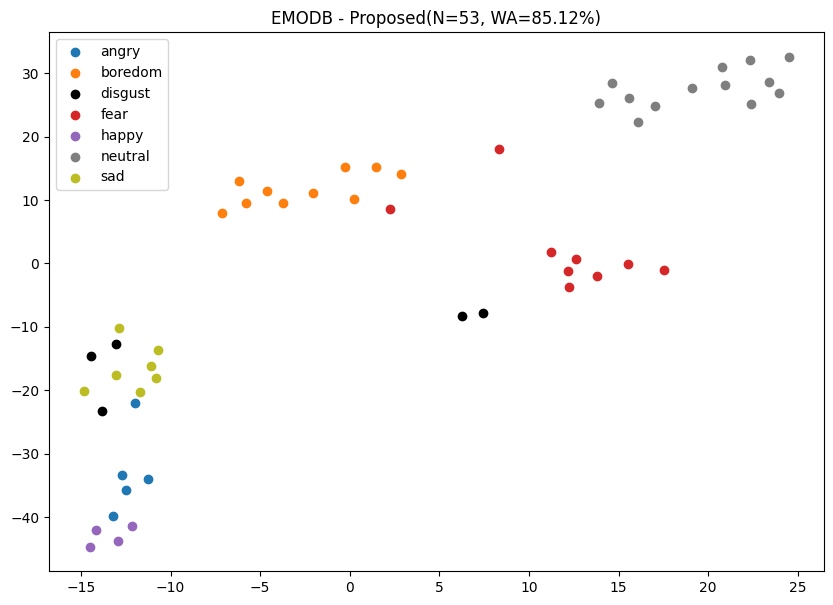

In [21]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

classes = CLASS_LABELS

for idx, c in enumerate(color_tables):
    indices = [i for i, l in enumerate(labels) if idx == l]
    cur_tx = np.take(tx, indices)
    cur_ty = np.take(ty, indices)
    ax.scatter(cur_tx, cur_ty, c=c, label=classes[idx])
    
ax.legend(loc='best')
plt.title(f'{DATA_PATH} - Proposed(N={len(labels)}, WA={worst_acc:.2f}%)')
plt.show()

In [22]:
kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in enumerate(kfold.split(x, y)):
    if i != best_fold:
        continue
    
    x_test, y_test = x[test], y[test]
    x_test = tf.expand_dims(x_test, axis=-1)

In [23]:
features = model2(x_test, training=False)
labels = np.argmax(y_test, axis=1)

tsne = TSNE(n_components=2, perplexity=5).fit_transform(features)
tx = tsne[:, 0]
ty = tsne[:, 1]

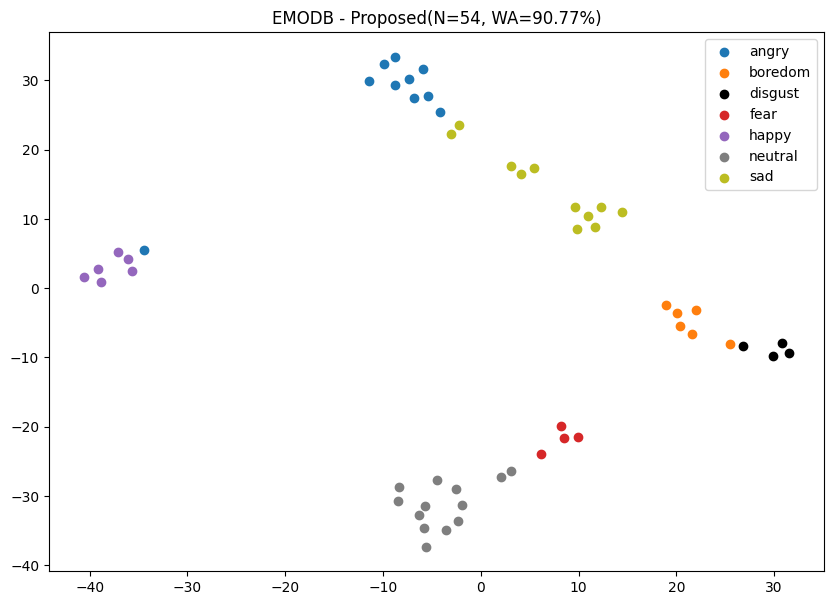

In [24]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

classes = CLASS_LABELS

for idx, c in enumerate(color_tables):
    indices = [i for i, l in enumerate(labels) if idx == l]
    cur_tx = np.take(tx, indices)
    cur_ty = np.take(ty, indices)
    ax.scatter(cur_tx, cur_ty, c=c, label=classes[idx])
    
ax.legend(loc='best')
plt.title(f'{DATA_PATH} - Proposed(N={len(labels)}, WA={best_acc:.2f}%)')
plt.show()